In [1]:
import matplotlib.pyplot as plt
import torch

from ptvi.algos.fivo import *
from ptvi import sgvb

In [2]:
torch.manual_seed(123)
T = 200
model = FilteredStochasticVolatilityModel(
    input_length=T, proposal=AR1Proposal(0, .95), num_particles=10)
model

Stochastic volatility model:
	x_t = exp(a * z_t/2) ε_t      t=1,...,200
	z_t = b + c * z_{t-1} + ν_t,  t=2,...,200
	z_1 ~ N(b, sqrt(1/(1 - c^2)))
	where ε_t, ν_t ~ Ν(0,1)

In [3]:
params = dict(a=1., b=0., c=.95)
y, z_true = model.simulate(**params)

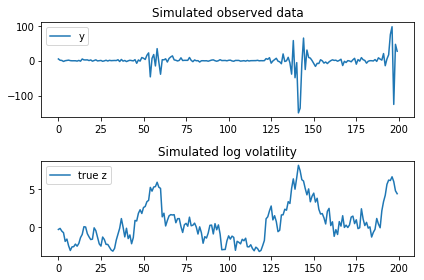

In [4]:
plt.subplot(211); plt.plot(y.numpy(), label='y')
plt.title('Simulated observed data')
plt.legend();
plt.subplot(212); plt.plot(z_true.numpy(), label='true z')
plt.legend()
plt.title('Simulated log volatility');
plt.tight_layout()

In [5]:
fit = sgvb(model, y)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Structured SGVB Inference: Particle filtered stochastic volatility model
  - Estimating elbo with M=1;
  - Minimum supremum growth heuristic (min_steps=500, patience=20, skip=10, ε=0.1)
  - Adadelta optimizer with param groups:
    group 0. lr=1.0, rho=0.9, eps=1e-06, weight_decay=0
  - Displayed loss is smoothed with λ=0.1
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
       0. smoothed elbo = -805.86
       1. smoothed elbo = -796.32
       2. smoothed elbo = -798.78
       4. smoothed elbo = -820.25
       8. smoothed elbo = -797.16
      16. smoothed elbo = -900.34
      32. smoothed elbo = -824.32
      64. smoothed elbo = -787.58
     128. smoothed elbo = -781.38
     256. smoothed elbo = -760.95
     512. smoothed elbo = -704.67
    1024. smoothed elbo = -648.11
    2048. smoothed elbo = -642.32
Stopping heuristic criterion satisfied
    2110. smoothed elbo = -638.

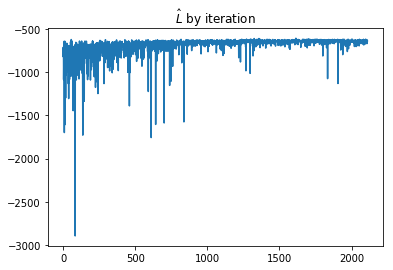

In [6]:
fit.plot_elbos()

In [7]:
fit.summary()

,mean,sd
a,2.612148,1.465436
b,-0.112257,0.224031
c,0.912120,0.027996


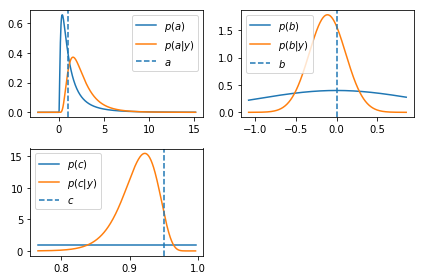

In [8]:
fit.plot_global_marginals(**params)